# This is a project which uses HR10 grating spectrum from the Gaia ESO survey.

The purpose of this is to aim to find unsuperised, latent space representations of the spectra using Variational Autoencoders. 

In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
from sklearn.preprocessing import MaxAbsScaler, RobustScaler, normalize, StandardScaler, MinMaxScaler
if("Spectral_analysis" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting

from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train


os.chdir("Spectral_analysis")
os.getcwd()

#plotting standards
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

# Data input for HR10 Sample

THE HR10 Giraffe spectra have been selected. We will use the data handling function to create a list of these
spectra with their object names. This simply opens the fits files and gets values of the spectrum wavelength, error and flux values for each spectra. All of the parameters for each of the spectrum were derived from WG15 and I have extracted them from the fits file and made them pandas readable.


In [2]:
os.chdir('../')
from Data_handling.spectra_object import get_data
os.chdir('Parameter_files')
HR10=pd.read_csv('HR10_parameter_with_file_names_for_spectra.csv')
os.chdir('../Data')
HR10['spectrum']=HR10['hr10_file'].apply(get_data)

# Learning spectrum

Next we will make our spectrum machine learning ready. First, we will remove all very erroneuous datapoints (5 sigma) in the flux for each spectrum. Then we will drop all spectra under a specific signal to noise ratio. Finally, we will transform the data into a PyTorch tensor.

We will replace highly erroneous flux values with the median for that spectrum. Make a signal to noise ratio cut.

In [3]:
def fill_high_error_data(spectrum,n_sigma=3):
    try:    #technical thing
        median = spectrum['flux_err'].median()
        std=spectrum['flux_err'].std()
        bound=median+n_sigma*std
        outliers = (spectrum['flux_err'])>bound
        spectrum['flux'][outliers] = np.nan
        spectrum['flux']=spectrum['flux'].fillna(median)
        return spectrum
    except:
        return 0 #this is done if that there is no values in the sp

In [4]:
HR10['spectrum']=HR10['spectrum'].apply(fill_high_error_data)

In [5]:
def row_type_isnt_int(row):
    return type(row)!=int

HR10=HR10[HR10['spectrum'].apply(row_type_isnt_int)]
#drop the spectrum indices with no values. I.e the ones where above returned a zero.

Number of datapoints with above certain SNR

In [6]:
print('Fraction of SNR we will use')
sum(HR10['SNR']>=20.0)/sum(HR10['SNR']>=0.0)

Fraction of SNR we will use


0.42045340050377833

Make the SNR cut

In [7]:
HR10=HR10[HR10['SNR']>=20.0]
HR10.reset_index(inplace=True)

Moving forward we will disregard our error for now

In [8]:
learning_spectra=[]
for i in range(0,len(HR10['spectrum'])):
    learning_spectra.append(HR10['spectrum'][i]['flux'])
    
learning_spectra=np.array(learning_spectra)
np.shape(learning_spectra)    

(20865, 5541)

# Normalise the data
We will apply a standard scaler to these spectra. In order to do so we will transpse them first so that we are scaling the spectra instelf and not each wavelength flux value.

In [9]:
scaler=StandardScaler()
scaler2=MinMaxScaler()
def normalised_pca(list_X): 
    X_train_scaled = scaler2.fit_transform(scaler.fit_transform(list_X))
    return X_train_scaled
learning_spectra=normalised_pca(learning_spectra.transpose()).transpose()

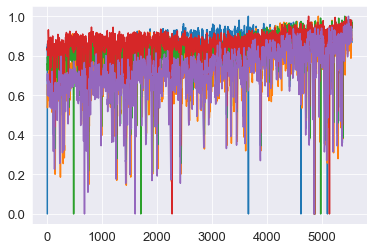

In [10]:
for i in range(5): 
    plt.plot(learning_spectra[100*i])


# Variational Autoencoders.

We are now going to apply a variational autoencoder to see if we can discover anything in the latent space.

In [11]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam
from torch.utils.data import DataLoader


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 3.0.1 Set Model Hyperparameters

In [12]:
#learning_spectra=learning_spectra-x_mean

In [13]:
batch_size = 100 #factor for 1090
lr = 1e-3
epochs = 50

# 3.1 Load in the Data

In [14]:
vae_spec=DataLoader(torch.tensor(learning_spectra).float(),batch_size=batch_size,drop_last=True) 

# 3.2 Model Setup

## 3.2.1 Set latent variables dimension


In [15]:
zdim=6

# 3.2.2 Define the VAE Model and Optimiser

In [16]:

encoder = Encoder(input_dim=learning_spectra.shape[1], hidden_dims=[50,10], z_dim=zdim,dropout=.2)
decoder = Decoder(output_dim=learning_spectra.shape[1], hidden_dims = [10,50], z_dim=zdim,dropout=.2)
model = VAE(Encoder=encoder, Decoder=decoder).to(DEVICE)
optimizer=Adam(model.parameters(),lr=lr)

# 3.3 Train model 

In [17]:
print("Start training VAE...")
model.train()
model_train(vae_spec=vae_spec,model=model,optimizer=optimizer,loss_function=loss_function,epochs=epochs,batch_size=batch_size)

Start training VAE...
	Epoch 1 complete! 	Average Loss:  465.6761196973128
Overall Loss:  9639495.677734375
KLD Loss:  tensor(4000.3923, grad_fn=<MulBackward0>)
	Epoch 2 complete! 	Average Loss:  119.48214914515398
Overall Loss:  2473280.4873046875
KLD Loss:  tensor(2662.9966, grad_fn=<MulBackward0>)
	Epoch 3 complete! 	Average Loss:  97.06080917874397
Overall Loss:  2009158.75
KLD Loss:  tensor(1229.4308, grad_fn=<MulBackward0>)
	Epoch 4 complete! 	Average Loss:  76.55681397663798
Overall Loss:  1584726.0493164062
KLD Loss:  tensor(417.1137, grad_fn=<MulBackward0>)
	Epoch 5 complete! 	Average Loss:  68.89718870301178
Overall Loss:  1426171.8061523438
KLD Loss:  tensor(177.7035, grad_fn=<MulBackward0>)
	Epoch 6 complete! 	Average Loss:  66.20929161477204
Overall Loss:  1370532.3364257812
KLD Loss:  tensor(168.6178, grad_fn=<MulBackward0>)
	Epoch 7 complete! 	Average Loss:  65.17986542780042
Overall Loss:  1349223.2143554688
KLD Loss:  tensor(26.4088, grad_fn=<MulBackward0>)
	Epoch 8 co

([tensor([[ 3.1283e+00,  3.8242e-01,  4.3463e+00,  2.9164e+00, -7.0505e+00,
           -2.6804e+00],
          [ 1.8723e+00,  2.6638e-01,  6.0945e+00,  1.7910e+00, -4.9030e+00,
           -3.3282e-01],
          [ 2.9372e+00,  1.7358e-01,  3.0999e+00,  2.8320e+00, -6.9578e+00,
            4.7921e-01],
          [ 1.5896e+00, -2.4356e-01,  4.2017e+00,  3.1014e+00, -5.1758e+00,
           -2.6263e+00],
          [ 3.3155e+00, -8.4854e-01,  4.4335e+00,  2.9843e+00, -7.6460e+00,
           -1.6098e+00],
          [ 3.6212e+00, -7.7516e-01,  4.2855e+00,  3.2259e+00, -6.4638e+00,
           -1.9310e+00],
          [ 4.7047e+00,  1.3995e+00,  4.2468e+00,  3.0464e+00, -6.0735e+00,
           -1.4912e+00],
          [ 3.2859e+00, -2.3326e+00,  4.6920e+00,  2.8075e+00, -8.3664e+00,
           -1.1223e+00],
          [ 4.5991e+00, -1.5641e+00,  3.0890e+00,  2.3104e+00, -7.7831e+00,
           -1.5580e+00],
          [ 3.3819e+00, -3.6343e-01,  4.6901e+00,  1.9373e+00, -6.9024e+00,
           -8.6

# 3.4 Reconstruction Accuracy

In [18]:
os.chdir('../')

In [19]:
input_names = ['Spec']
output_names = ['Spec reconstructed']
torch.onnx.export(model, torch.tensor(learning_spectra), 'rnn.onnx', input_names=input_names, output_names=output_names)

In [20]:
#from torchviz import make_dot

#make_dot(model(torch.tensor(learning_spectra)), params=dict(list(model.named_parameters()))).render("vae_spec", format="png")

In [21]:
learning_spectra=learning_spectra[:,np.newaxis,:]

In [22]:
model.eval()
output=model(torch.tensor(learning_spectra))
x_recon=output[0].detach().numpy()
mean=output[1].detach().numpy()
log_var=output[2].detach().numpy()
z=output[3].detach().numpy()


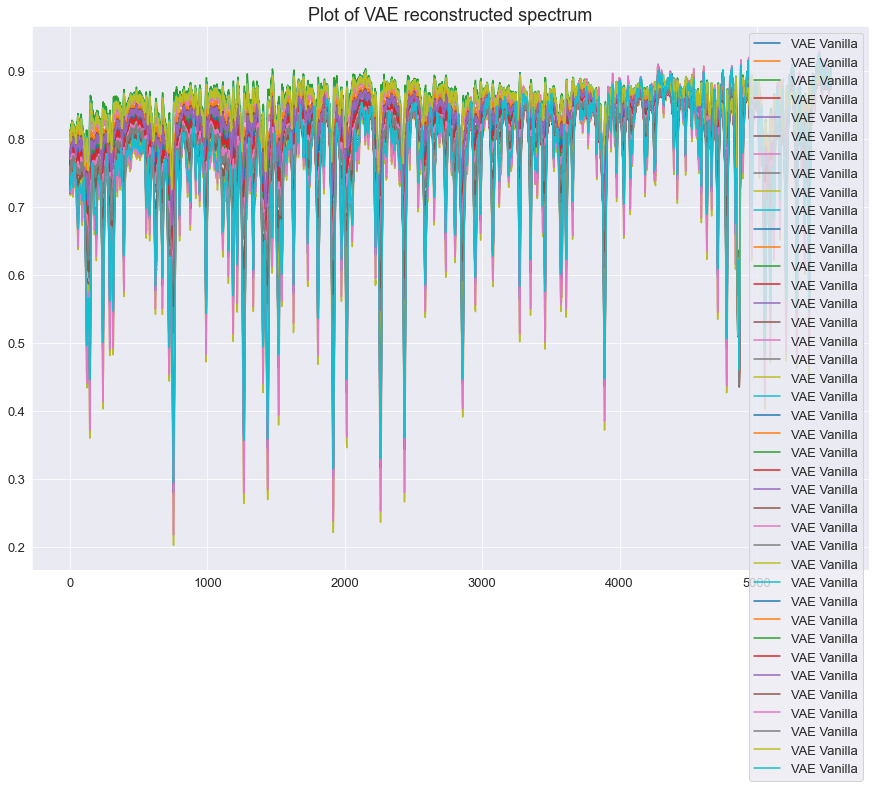

In [23]:
plt.figure(figsize=(15,10))
for i in range (40):
    plt.plot(x_recon[10*i][0],label='VAE Vanilla')



plt.legend()
plt.title('Plot of VAE reconstructed spectrum')
plt.show()

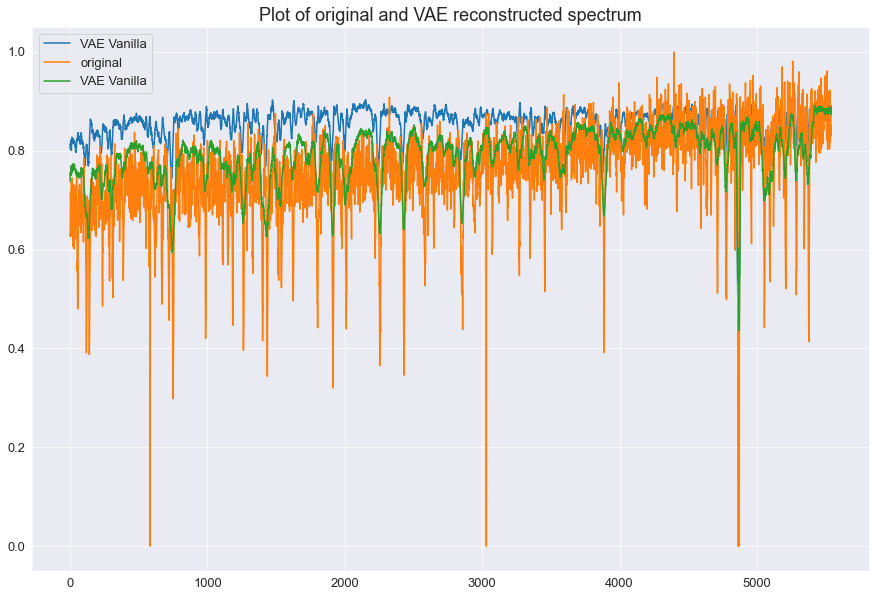

In [24]:
plt.figure(figsize=(15,10))
#lt.plot(learning_spectra[200][0],label='original')
plt.plot(x_recon[20][0],label='VAE Vanilla')

plt.plot(learning_spectra[230][0],label='original')
plt.plot(x_recon[230][0],label='VAE Vanilla')
#plt.ylim(0.005,0.020)
plt.title('Plot of original and VAE reconstructed spectrum')
plt.legend()
plt.show()

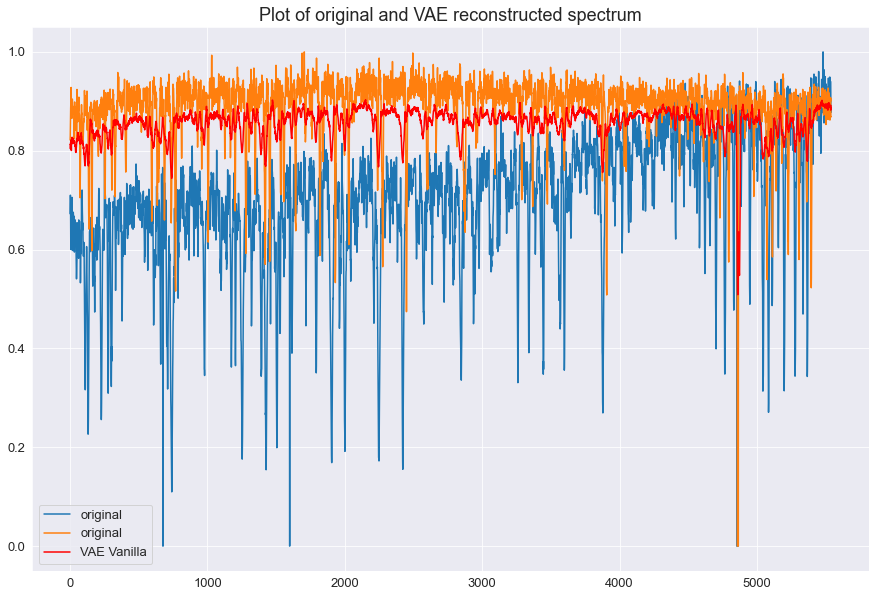

In [25]:
plt.figure(figsize=(15,10))
plt.plot(learning_spectra[400][0],label='original')
#plt.plot(x_recon[400][0],label='VAE Vanilla',color='red')

plt.plot(learning_spectra[20][0],label='original')
plt.plot(x_recon[20][0],label='VAE Vanilla',color='red')
#plt.ylim(0.005,0.020)
plt.title('Plot of original and VAE reconstructed spectrum')
plt.legend()
plt.show()

# 3.5 Analysis of Latent Parameters

In [26]:
z=z.reshape([z.shape[0],z.shape[-1]])

In [27]:
z.shape

(20865, 6)

In [28]:
pca_coeff=pd.DataFrame(data=z)
analysis=HR10.loc[:, HR10.columns != 'spectrum']

In [29]:
param=['DIST_GAIA','TEFF', 'LOGG', 'FEH', 'VRAD']#, 'XI']

<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

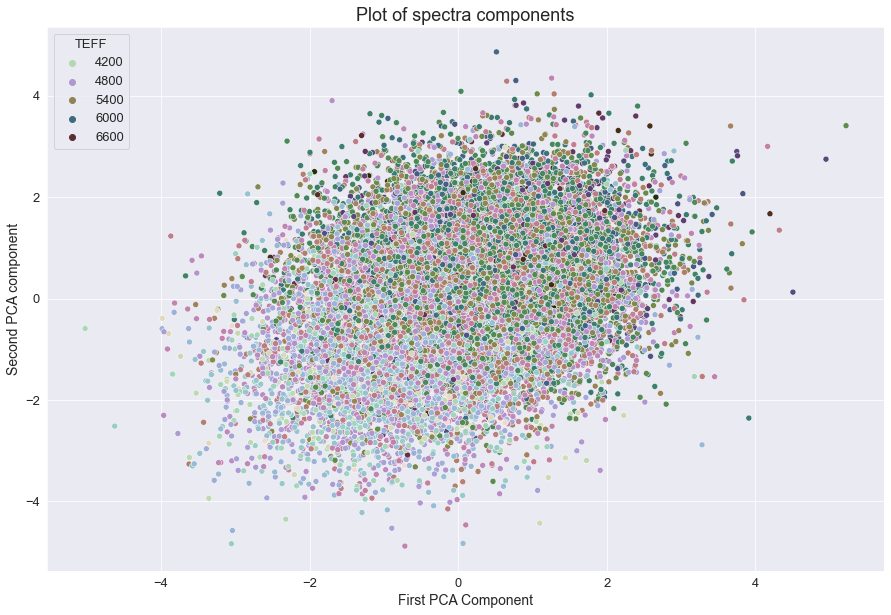

In [34]:
i=1
pca_analysis=pd.concat([analysis[param],pca_coeff],axis=1)
pca_analysis=pca_analysis[pca_analysis[param[i]]!='nan']

pca_analysis[param[i]]=pca_analysis[param[i]].astype(float)

plt.figure(figsize=(15,10))
sn.scatterplot(data=pca_analysis,x=2,y=0, hue=param[i], palette="ch:r=-3,l=0.9")

plt.title('Plot of spectra components')
plt.ylabel('Second PCA component')
plt.xlabel('First PCA Component')

sn.heatmap

Text(0.5, 0, 'First PCA Component')

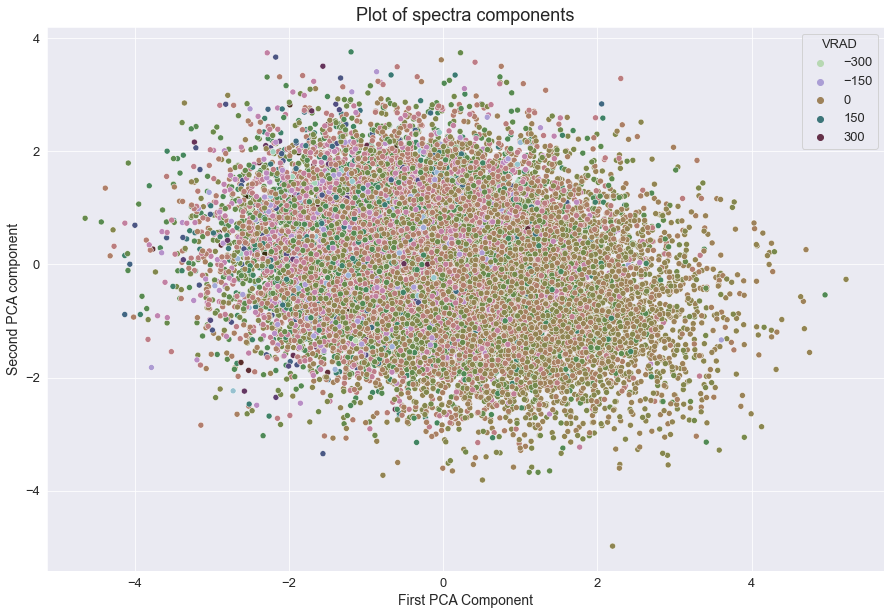

In [31]:
i=4
pca_analysis=pd.concat([analysis[param],pca_coeff],axis=1)
pca_analysis=pca_analysis[pca_analysis[param[i]]!='nan']

pca_analysis[param[i]]=pca_analysis[param[i]].astype(float)

plt.figure(figsize=(15,10))
sn.scatterplot(data=pca_analysis,x=1,y=3, hue=param[i], palette="ch:r=-3,l=0.9")

plt.title('Plot of spectra components')
plt.ylabel('Second PCA component')
plt.xlabel('First PCA Component')

<AxesSubplot:xlabel='4', ylabel='TEFF'>

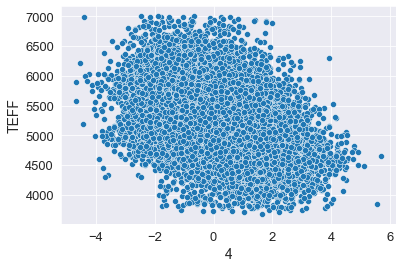

In [32]:
sn.scatterplot(data=pca_analysis,x=4,y='TEFF')

In [33]:
corr=pca_analysis.corr().loc[param]
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_6560/3384151885.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,DIST_GAIA,TEFF,LOGG,FEH,VRAD,0,1,2,3,4,5
DIST_GAIA,1.00,-0.04,0.07,-0.03,-0.06,-0.03,0.02,-0.03,-0.01,0.04,0.04
TEFF,-0.04,1.00,0.47,0.01,0.06,0.36,-0.37,0.28,0.23,-0.40,-0.36
LOGG,0.07,0.47,1.00,0.38,-0.08,-0.02,0.02,-0.03,-0.01,0.03,0.02
FEH,-0.03,0.01,0.38,1.00,-0.16,-0.24,0.25,-0.19,-0.15,0.27,0.24
VRAD,-0.06,0.06,-0.08,-0.16,1.00,0.06,-0.06,0.05,0.03,-0.06,-0.06
